In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.images.shape
num_test=mnist.test.images.shape

In [3]:
X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1],name='X')
y=tf.placeholder(dtype=tf.int64,shape=[None,10],name='y')
is_training=tf.placeholder(dtype=tf.bool,name='is_training')
cnn_out1=tf.layers.conv2d(X,128,kernel_size=3,strides=(1, 1),padding='same')
bn_out1=tf.layers.batch_normalization(cnn_out1,axis=3,training=is_training)
relu_out1=tf.nn.relu(bn_out1)
pool_out1=tf.layers.max_pooling2d(relu_out1,[2,2],[2,2])
cnn_out2=tf.layers.conv2d(pool_out1,128,kernel_size=3,strides=(1, 1),padding='same')
bn_out2=tf.layers.batch_normalization(cnn_out2,axis=3,training=is_training)
relu_out1=tf.nn.relu(bn_out2)
pool_out2=tf.layers.max_pooling2d(relu_out1,[2,2],[2,2])
flt=tf.layers.flatten(pool_out2)
out1=tf.layers.dense(flt,1024)
# bn_out3=tf.layers.batch_normalization(out1,axis=1,training=is_training)
out2=tf.nn.relu(out1)
score=tf.layers.dense(out2,10)
predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-6)
train_step = optimizier.minimize(loss)

In [4]:
max_epoch=50
batch_size=8
print_every=625

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        loss_num,_ = sess.run([loss,train_step],feed_dict={X:images.reshape(-1,28,28,1),y:labels,is_training:True})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images.reshape(-1,28,28,1),y:labels,is_training:False})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy
    
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,2000)
        loss_val,acc_val=eval(mnist.validation,500)
        loss_test,acc_test=eval(mnist.test,1000)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-13 17:41:56 start epoch 1/50:
2018-04-13 17:41:57 iteration 1/6875: current training loss = 3.083660
2018-04-13 17:42:00 iteration 625/6875: current training loss = 1.272324
2018-04-13 17:42:02 iteration 1250/6875: current training loss = 0.537513
2018-04-13 17:42:05 iteration 1875/6875: current training loss = 0.483856
2018-04-13 17:42:07 iteration 2500/6875: current training loss = 0.385862
2018-04-13 17:42:10 iteration 3125/6875: current training loss = 0.712461
2018-04-13 17:42:13 iteration 3750/6875: current training loss = 0.320487
2018-04-13 17:42:15 iteration 4375/6875: current training loss = 0.391533
2018-04-13 17:42:18 iteration 5000/6875: current training loss = 0.166195
2018-04-13 17:42:20 iteration 5625/6875: current training loss = 0.367317
2018-04-13 17:42:23 iteration 6250/6875: current training loss = 0.047774
2018-04-13 17:42:26 iteration 6875/6875: current training loss = 0.671304
2018-04-13 17:42:32 end epoch 1/50: acc_train=77.569% acc_val=79.200% acc_test

2018-04-13 17:46:42 iteration 1250/6875: current training loss = 0.007404
2018-04-13 17:46:45 iteration 1875/6875: current training loss = 0.038815
2018-04-13 17:46:47 iteration 2500/6875: current training loss = 0.023837
2018-04-13 17:46:50 iteration 3125/6875: current training loss = 0.006166
2018-04-13 17:46:53 iteration 3750/6875: current training loss = 0.001890
2018-04-13 17:46:55 iteration 4375/6875: current training loss = 0.013509
2018-04-13 17:46:58 iteration 5000/6875: current training loss = 0.581377
2018-04-13 17:47:00 iteration 5625/6875: current training loss = 0.020825
2018-04-13 17:47:03 iteration 6250/6875: current training loss = 0.012956
2018-04-13 17:47:05 iteration 6875/6875: current training loss = 0.001586
2018-04-13 17:47:11 end epoch 9/50: acc_train=97.319% acc_val=96.950% acc_test=97.225%
2018-04-13 17:47:11 start epoch 10/50:
2018-04-13 17:47:11 iteration 1/6875: current training loss = 0.005783
2018-04-13 17:47:14 iteration 625/6875: current training loss =

2018-04-13 17:51:21 iteration 2500/6875: current training loss = 0.008049
2018-04-13 17:51:24 iteration 3125/6875: current training loss = 0.003444
2018-04-13 17:51:27 iteration 3750/6875: current training loss = 0.015647
2018-04-13 17:51:29 iteration 4375/6875: current training loss = 0.041330
2018-04-13 17:51:32 iteration 5000/6875: current training loss = 0.002378
2018-04-13 17:51:34 iteration 5625/6875: current training loss = 0.007615
2018-04-13 17:51:37 iteration 6250/6875: current training loss = 0.010574
2018-04-13 17:51:39 iteration 6875/6875: current training loss = 0.032308
2018-04-13 17:51:45 end epoch 17/50: acc_train=97.513% acc_val=97.400% acc_test=97.175%
2018-04-13 17:51:45 start epoch 18/50:
2018-04-13 17:51:45 iteration 1/6875: current training loss = 0.001264
2018-04-13 17:51:47 iteration 625/6875: current training loss = 0.024492
2018-04-13 17:51:50 iteration 1250/6875: current training loss = 0.005093
2018-04-13 17:51:52 iteration 1875/6875: current training loss 

2018-04-13 17:56:02 iteration 3750/6875: current training loss = 0.002358
2018-04-13 17:56:04 iteration 4375/6875: current training loss = 0.001308
2018-04-13 17:56:07 iteration 5000/6875: current training loss = 0.018116
2018-04-13 17:56:09 iteration 5625/6875: current training loss = 0.000212
2018-04-13 17:56:12 iteration 6250/6875: current training loss = 0.001722
2018-04-13 17:56:14 iteration 6875/6875: current training loss = 0.004283
2018-04-13 17:56:20 end epoch 25/50: acc_train=96.944% acc_val=96.500% acc_test=96.213%
2018-04-13 17:56:20 start epoch 26/50:
2018-04-13 17:56:20 iteration 1/6875: current training loss = 0.001250
2018-04-13 17:56:23 iteration 625/6875: current training loss = 0.006684
2018-04-13 17:56:25 iteration 1250/6875: current training loss = 0.009406
2018-04-13 17:56:27 iteration 1875/6875: current training loss = 0.004368
2018-04-13 17:56:30 iteration 2500/6875: current training loss = 0.031838
2018-04-13 17:56:32 iteration 3125/6875: current training loss 

2018-04-13 18:00:44 iteration 5000/6875: current training loss = 0.008785
2018-04-13 18:00:46 iteration 5625/6875: current training loss = 0.000127
2018-04-13 18:00:49 iteration 6250/6875: current training loss = 0.006951
2018-04-13 18:00:51 iteration 6875/6875: current training loss = 0.000772
2018-04-13 18:00:58 end epoch 33/50: acc_train=96.438% acc_val=95.675% acc_test=95.425%
2018-04-13 18:00:58 start epoch 34/50:
2018-04-13 18:00:58 iteration 1/6875: current training loss = 0.000730
2018-04-13 18:01:00 iteration 625/6875: current training loss = 0.005548
2018-04-13 18:01:03 iteration 1250/6875: current training loss = 0.005305
2018-04-13 18:01:05 iteration 1875/6875: current training loss = 0.000722
2018-04-13 18:01:08 iteration 2500/6875: current training loss = 0.000363
2018-04-13 18:01:10 iteration 3125/6875: current training loss = 0.000097
2018-04-13 18:01:13 iteration 3750/6875: current training loss = 0.005292
2018-04-13 18:01:15 iteration 4375/6875: current training loss 

2018-04-13 18:05:24 iteration 6250/6875: current training loss = 0.002048
2018-04-13 18:05:27 iteration 6875/6875: current training loss = 0.000028
2018-04-13 18:05:33 end epoch 41/50: acc_train=94.506% acc_val=94.200% acc_test=93.950%
2018-04-13 18:05:33 start epoch 42/50:
2018-04-13 18:05:33 iteration 1/6875: current training loss = 0.000561
2018-04-13 18:05:36 iteration 625/6875: current training loss = 0.001908
2018-04-13 18:05:38 iteration 1250/6875: current training loss = 0.000213
2018-04-13 18:05:41 iteration 1875/6875: current training loss = 0.000894
2018-04-13 18:05:43 iteration 2500/6875: current training loss = 0.000159
2018-04-13 18:05:46 iteration 3125/6875: current training loss = 0.000070
2018-04-13 18:05:48 iteration 3750/6875: current training loss = 0.001606
2018-04-13 18:05:51 iteration 4375/6875: current training loss = 0.000170
2018-04-13 18:05:54 iteration 5000/6875: current training loss = 0.001890
2018-04-13 18:05:56 iteration 5625/6875: current training loss 

2018-04-13 18:10:10 end epoch 49/50: acc_train=94.388% acc_val=94.450% acc_test=93.362%
2018-04-13 18:10:10 start epoch 50/50:
2018-04-13 18:10:10 iteration 1/6875: current training loss = 0.000009
2018-04-13 18:10:12 iteration 625/6875: current training loss = 0.001656
2018-04-13 18:10:15 iteration 1250/6875: current training loss = 0.000122
2018-04-13 18:10:18 iteration 1875/6875: current training loss = 0.000226
2018-04-13 18:10:20 iteration 2500/6875: current training loss = 0.000012
2018-04-13 18:10:23 iteration 3125/6875: current training loss = 0.001295
2018-04-13 18:10:25 iteration 3750/6875: current training loss = 0.000003
2018-04-13 18:10:28 iteration 4375/6875: current training loss = 0.000023
2018-04-13 18:10:30 iteration 5000/6875: current training loss = 0.000154
2018-04-13 18:10:33 iteration 5625/6875: current training loss = 0.002574
2018-04-13 18:10:36 iteration 6250/6875: current training loss = 0.025145
2018-04-13 18:10:38 iteration 6875/6875: current training loss 

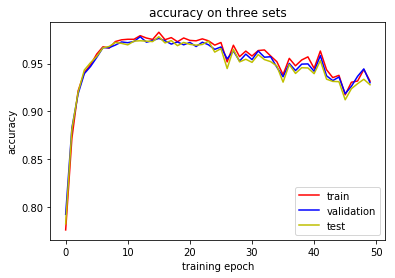

In [5]:
plt.figure(1)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()